## Group: Jingmin Chen, Tianyu Sun

# Introduction

In this project I'll use neural network to predict cut level of diamonds. The dataset contains some attributes of diamond observations and cut level for prediction. My work will divided into several steps shown below.

1.  load data and understand meanings of each features
2.  perform some EDA to get some useful information for future work
3.  perform data preparation to make dataset suitable for ML models.
4.  perfrom variable selection to generate different datasets
5.  train models

Detail will be described in each step.

In [3]:
# load python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score, accuracy_score, confusion_matrix, make_scorer, classification_report, precision_score, balanced_accuracy_score, average_precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier


## Load data

In this part I'll load data from file and try to understand meanings of each attribute.

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/TTZUO/DAV-6150/master/Project3_Data.csv')

print(data.shape)
print(data.columns)

(53940, 10)
Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')


The meanings of each variable is shown below:

-   `price`: price in US dollars (\$326--\$18,823)

-   `carat`: weight of the diamond (0.2--5.01)

-   `cut`: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

-   `color`: diamond colour, from D (best) to J (worst)

-   `clarity`: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

-   `x`: length in mm (0--10.74)

-   `y`: width in mm (0--58.9)

-   `z`: depth in mm (0--31.8)

-   `depth`: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

-   `table`: width of top of diamond relative to widest point (43--95)

## EDA

In this part I'll perform some EDA on the dataset to explore some basic features of dataset along with distributions of each variable and relationship between variables.

Take a look on the dataset

In [29]:
print(data.head())

carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75


In [30]:
print(np.unique(data.cut))

['Fair' 'Good' 'Ideal' 'Premium' 'Very Good']


In [31]:
print(data.dtypes)


carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object


Here I found that there are 7 numerical variables including response variable (`carat`, `depth`, `table`, `x`, `y`, `z`, `price`) and 3 categorical variables (`cut`, `color`, `clarity`). I'll use different method to explore different type of variable.

In [32]:
print(data.isnull().sum())

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


It is good that there is no empty observation in dataset.

In [33]:
categorical_var = ['color', 'clarity']
numeric_var = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
response_var = 'cut'

For categorical variables, I'll take a look at the valid values and number of them.

In [34]:
print(data[response_var].value_counts())

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64


Here I found that `cut` is not balance, `Good` and `Fair` are less then others. Many diamonds used as gem must have a good cut to sold in a high price, maybe that's why there are fewer `Good` and `Fair`.

Here are other value counts of categorical variables.

In [35]:
for f in categorical_var:
    print(f, '\n', data[f].value_counts(), '\n')

color 
 G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64 

clarity 
 SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64 



Here are some basic statistic metrics of numerical variables.

In [36]:
print(data[numeric_var].describe())

carat         depth         table         price             x  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean       0.797940     61.749405     57.457184   3932.799722      5.731157   
std        0.474011      1.432621      2.234491   3989.439738      1.121761   
min        0.200000     43.000000     43.000000    326.000000      0.000000   
25%        0.400000     61.000000     56.000000    950.000000      4.710000   
50%        0.700000     61.800000     57.000000   2401.000000      5.700000   
75%        1.040000     62.500000     59.000000   5324.250000      6.540000   
max        5.010000     79.000000     95.000000  18823.000000     10.740000   

                  y             z  
count  53940.000000  53940.000000  
mean       5.734526      3.538734  
std        1.142135      0.705699  
min        0.000000      0.000000  
25%        4.720000      2.910000  
50%        5.710000      3.530000  
75%        6.540000      4.040000  
max       58.9

I found that there are some 0s in these variables which is not valid.

In [37]:
for f in numeric_var:
    
    cnt = data[f][data[f] == 0].shape[0]
    print(f, cnt)

carat 0
depth 0
table 0
price 0
x 8
y 7
z 20


`x` has 8 zeros, `y` has 7 zeros and `z` has 20 zeros. I think it is necessary to see how many outliers in these variables. I'll use boxplot to do that.

I'll regard value out of bounds (upper bound and lower bound) as outliers. Upper bound and lower bound are calculated by quartile.

$$
\begin{cases}
    X_{upper} = Q_3 + 1.5 \times IQR\\
    X_{lower} = Q_1 - 1.5 \times IQR\\
\end{cases}
$$


    carat:
    25%: 1.04
    75%: 0.4
    IQR: 0.64
    upper bound: 2.0
    lower bound: -0.5599999999999999
    outlisers: 1889
    zeros: 0


    depth:
    25%: 62.5
    75%: 61.0
    IQR: 1.5
    upper bound: 64.75
    lower bound: 58.75
    outlisers: 2545
    zeros: 0


    table:
    25%: 59.0
    75%: 56.0
    IQR: 3.0
    upper bound: 63.5
    lower bound: 51.5
    outlisers: 605
    zeros: 0


    price:
    25%: 5324.25
    75%: 950.0
    IQR: 4374.25
    upper bound: 11885.625
    lower bound: -5611.375
    outlisers: 3540
    zeros: 0
    

    x:
    25%: 6.54
    75%: 4.71
    IQR: 1.83
    upper bound: 9.285
    lower bound: 1.9649999999999999
    outlisers: 32
    zeros: 8
    

    y:
    25%: 6.54
    75%: 4.72
    IQR: 1.8200000000000003
    upper bound: 9.27
    lower bound: 1.9899999999999993
    outlisers: 29
    zeros: 7
    

    z:
    25%: 4.04
    75%: 2.91
    IQR: 1.13
    upper bound: 5.734999999999999
    lower bound: 1.2150000000000003
    outlisers: 

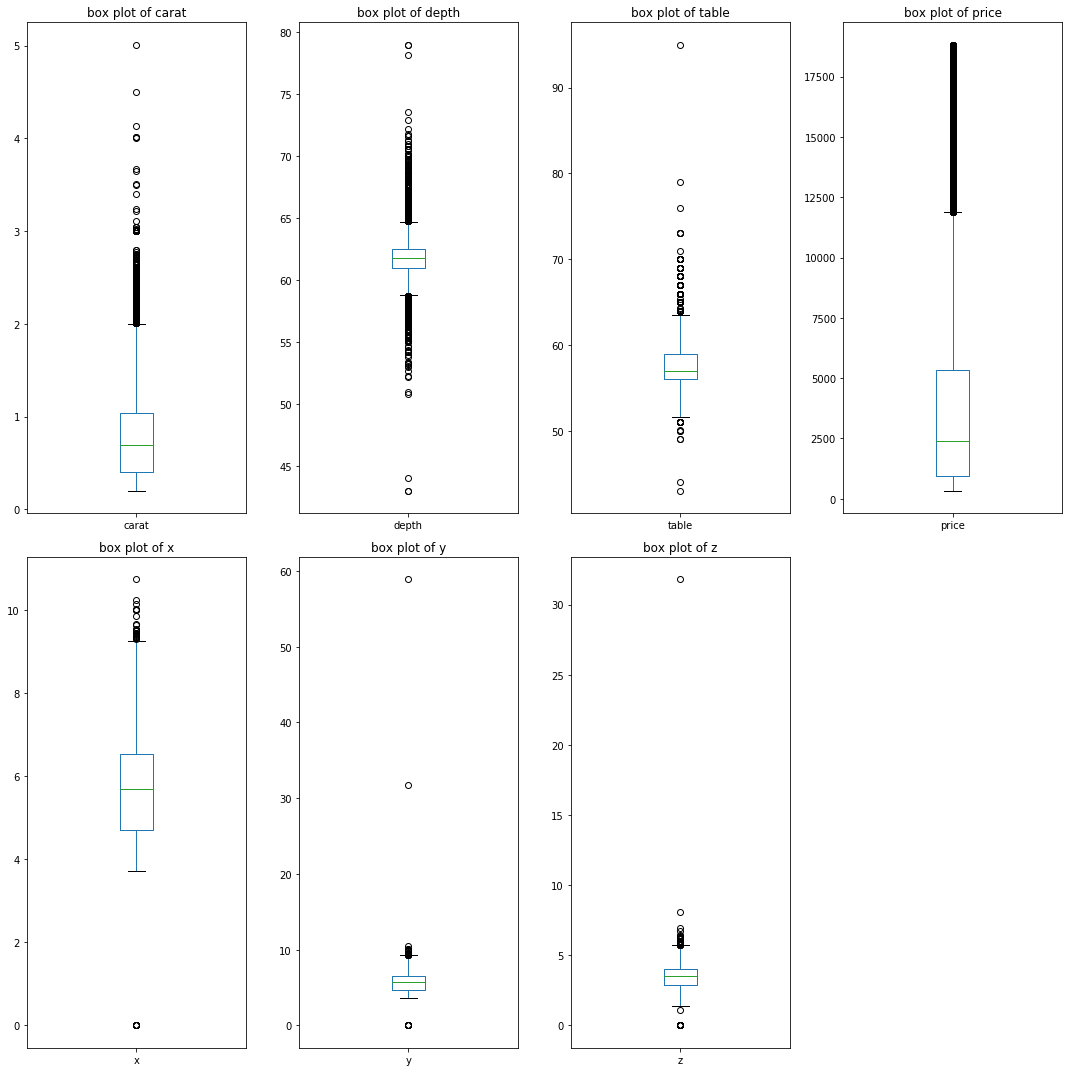

In [38]:
plt.figure(figsize=(15, 15))

i = 1
for f in numeric_var:

    plt.subplot(2, 4, i)
    data[f].plot.box()
    plt.title('box plot of {}'.format(f))
    plt.tight_layout()

    q1 = data[f].quantile(0.25)
    q3 = data[f].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr

    outlier_count = data[f][(data[f] > upper_bound) | (data[f] < lower_bound)].shape[0]

    zero_count = (data[f] == 0).sum()

    print('''
    {}:
    25%: {}
    75%: {}
    IQR: {}
    upper bound: {}
    lower bound: {}
    outlisers: {}
    zeros: {}
    '''.format(f, q3, q1, iqr, upper_bound, lower_bound, outlier_count, zero_count))


    i += 1

And then see bar plot on categorical variables.

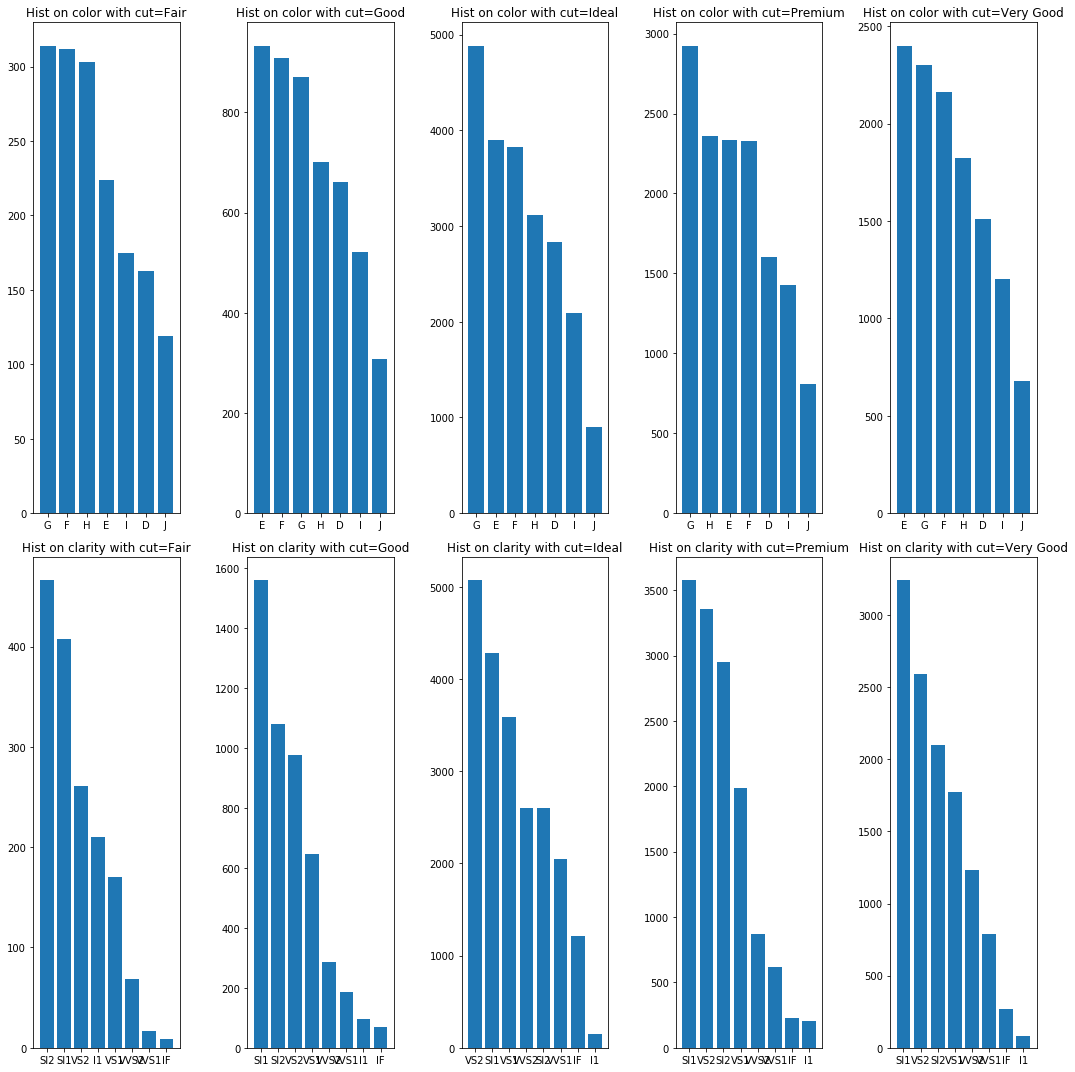

In [39]:
fig = plt.figure(figsize=(15, 15))

i = 1
for f in categorical_var:

    for rv in np.unique(data[response_var]):
        
        plt.subplot(2, 5, i)
        val_cnt = data[f][data[response_var] == rv].value_counts()
        plt.bar(x=val_cnt.index, height=val_cnt.values)
        plt.title('Hist on {} with cut={}'.format(f, rv))
        plt.tight_layout()

        i += 1
plt.show()

As we can see that the distribution on each categorial variable when response variable equal to different value are similar. Maybe categorial data can't distinguish response variable very well.

Now for numeric variables

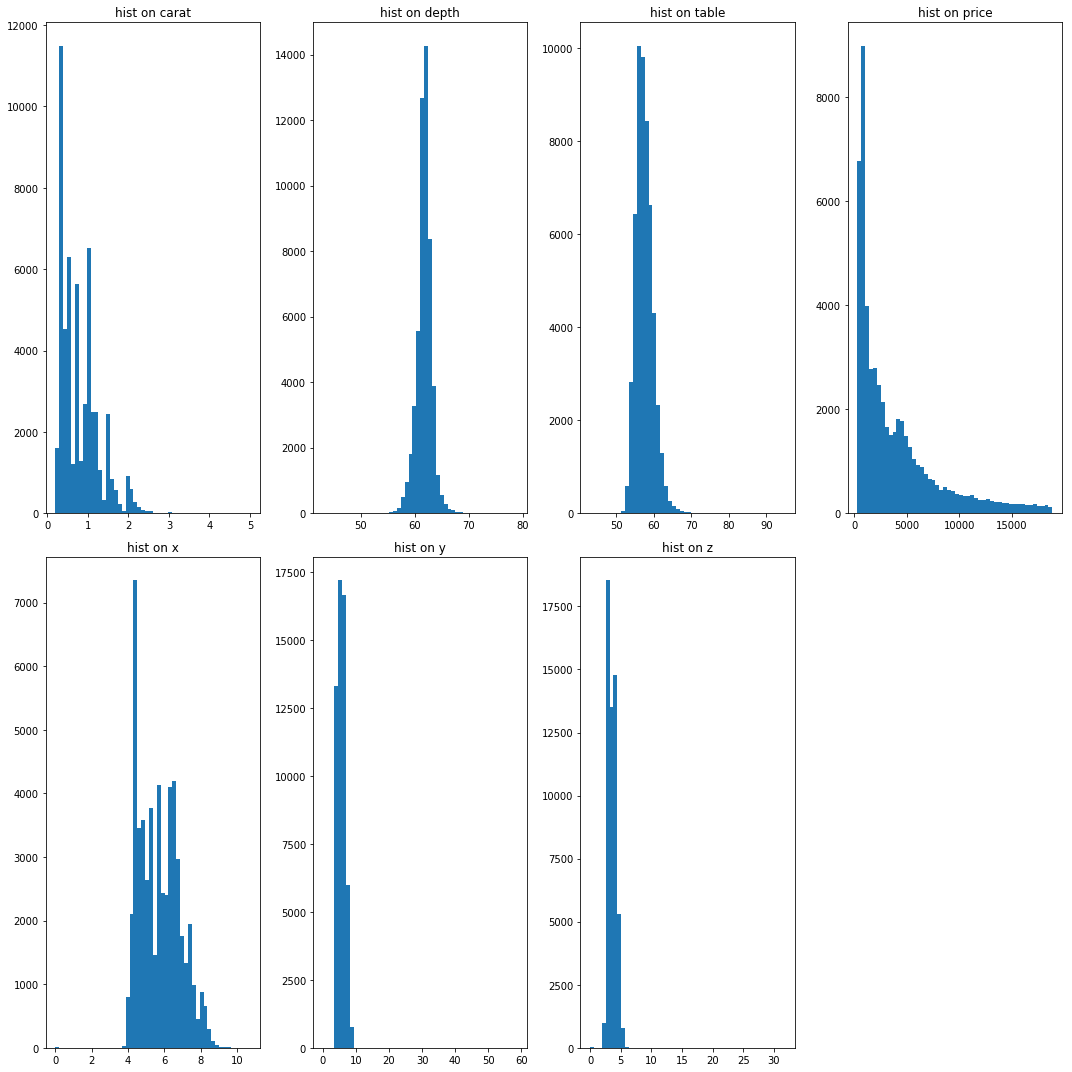

In [40]:
fig = plt.figure(figsize=(15, 15))
i = 1
for f in numeric_var:

    plt.subplot(2, 4, i)
    plt.hist(data[f], bins=50)
    plt.title('hist on {}'.format(f))
    plt.tight_layout()

    i += 1
plt.show()


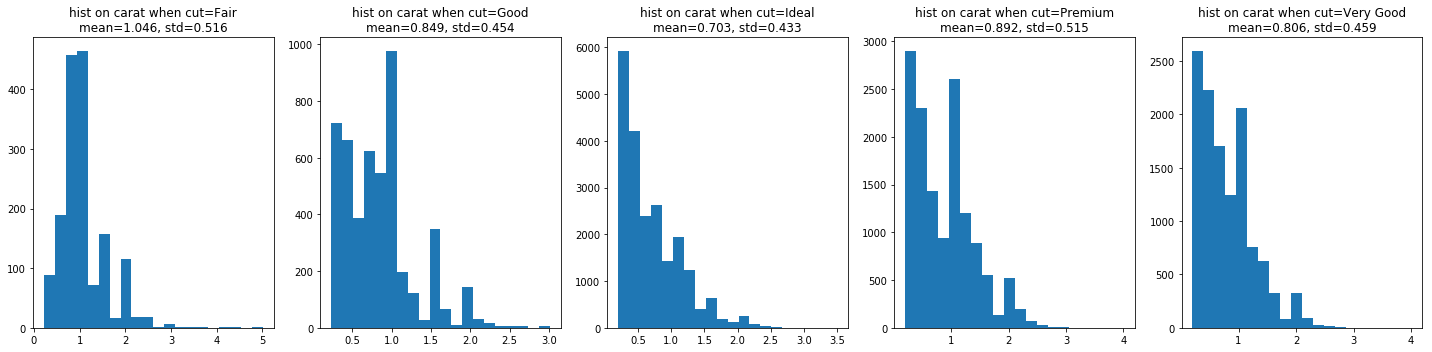

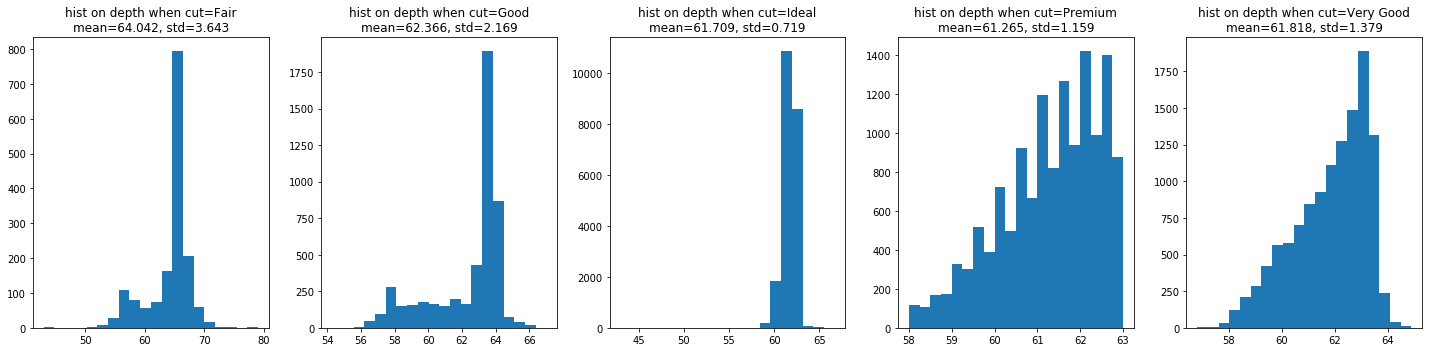

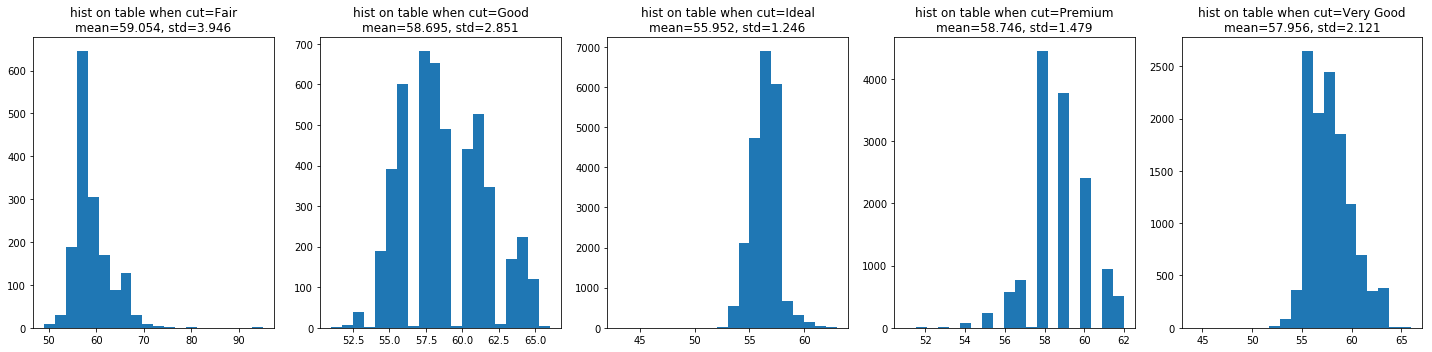

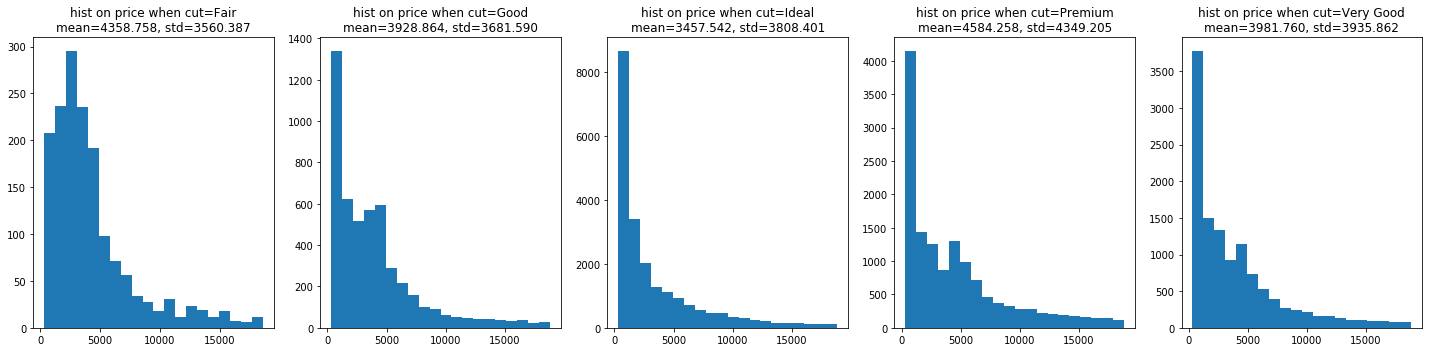

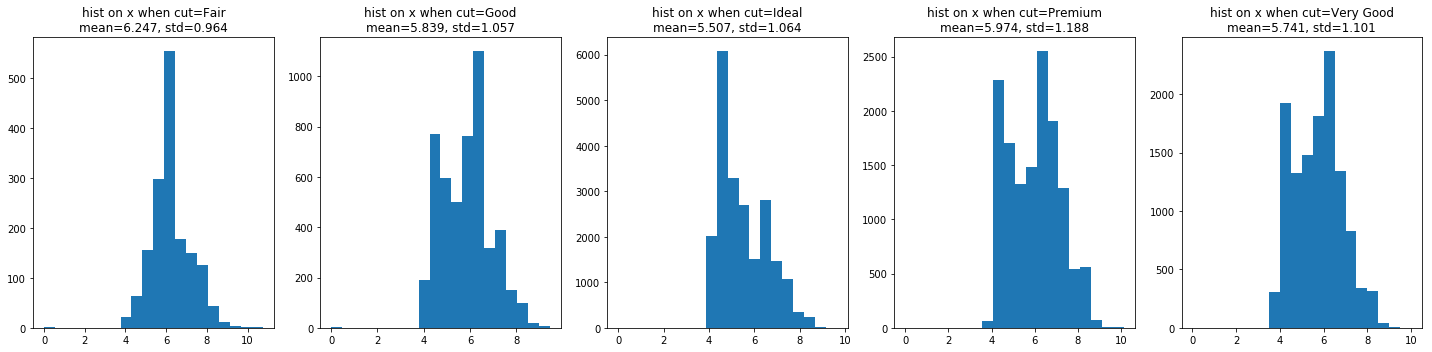

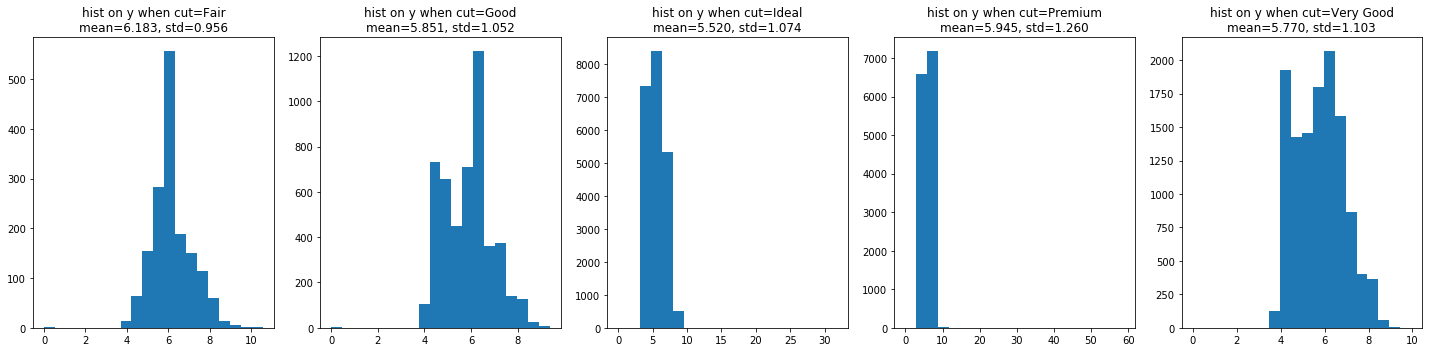

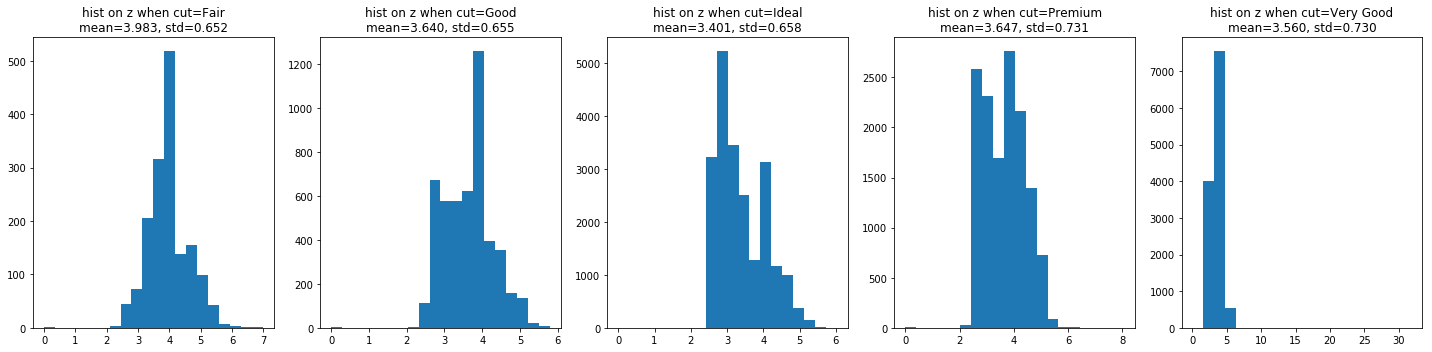

In [41]:
for f in numeric_var:

    fig = plt.figure(figsize=(20, 5))
    i = 1
    for rv in np.unique(data[response_var]):
        
        var = data[f][data[response_var] == rv]

        plt.subplot(1, 5, i)
        plt.hist(var, bins=20)
        plt.title('hist on {} when cut={}\nmean={:.3f}, std={:.3f}'.format(f, rv, var.mean(), var.std()))
        plt.tight_layout()

        i += 1
    plt.show()

As we can see that distribution of each variable on each response value are different. And we can see the difference by histograms, mean values and standard diviations. `carat`, `depth`, `table`, `y` and `z` seems to distinguish response value well. 

I have tried many methods to handle outliers such as drop them and impute them with a value (average value, nearset bounds), but all methods changed the distribution of this variable or other variable. It may caused by skewed distribution of variable. 

And I found that neural network is strong enough to handle empty value and outliers, and this dataset is big enough, so I'll just remove observations which has 0 in numerical variables.

In [42]:
print(data.shape)

for f in numeric_var:

    index = data.index[data[f] == 0].tolist()

    data.drop(index, inplace=True)

print(data.shape)

(53940, 10)
(53920, 10)


And the I'll measure relationship between explanatory variables and response variable. I'll use mutual information score to measure relationship between categorial explanatory variables and response variable. Because mutual information score is suitable for categorial variables and numeric variables, and it measures how related the two variables are. 

In [43]:
nmi_score = {}

In [44]:
for f in categorical_var:

    score = normalized_mutual_info_score(data[f], data[response_var])
    nmi_score[f] = score
    print('{} ~ {}: {}'.format(f, response_var, score))

color ~ cut: 0.001799927943550275
clarity ~ cut: 0.02018007060117365


In [45]:
for f in numeric_var:

    score = normalized_mutual_info_score(data[f], data[response_var])
    print('{} ~ {}: {}'.format(f, response_var, score))

    nmi_score[f] = score

carat ~ cut: 0.033516334310223404
depth ~ cut: 0.15349977367970952
table ~ cut: 0.18494971967431317
price ~ cut: 0.1401971271550344
x ~ cut: 0.042720126995294316
y ~ cut: 0.03658759193543398
z ~ cut: 0.031863138124667185


I can see the relationship between each explanatory variables and response variables by normalized mutual information score, higher value indicates more related. And these values can be useful in variable selection.

The result is similar to what we get from histograms. Categorial variables have a weak relationship with response variable so their NMI is small. It is obviously that color of diamound and weight of it will not influence difficulty of cutting. So I think that's why categorical variables not related to cut so much. And `depth`, `table` `price` have a high NMI value, these variables are regard as high-related variabels with response variable when I took a look at the histograms. It is obviously that a diamound with good cut will sold in a higher price, but most diamounds are not sold in very very high price. And maybe size of diamounds (reflect in `table`, `depth`, `x`, `y` and `z`) influences difficulity of cutting. So these variables are related. 

## Variable selection

Variable selection will based on NMI score obtained previously. I think variables with a higher NMI score may help to prediction. Because these variable are strong related to response variable and there may be some hidden information between them which can be explored by ML model. These hidden information may help ML model to perform prediction.

I'll set thershold to 0.03 to determain which variable will remain.

In [46]:
remaining_var = []
thresh = 0.03

for k, v in nmi_score.items():

    if v > thresh:
        remaining_var.append(k)
print(remaining_var)

['carat', 'depth', 'table', 'price', 'x', 'y', 'z']


There are 7 variable remaining.

## Data preparation

At first I'll convert the dataset to suitable format for neural networks. I'll standardize numerical variables and convert categorical variables into one-hot format or integer labels.

In [47]:
proc_data = data[remaining_var]
label = data[response_var]

We know that response variable is categorial variable and it is comparable (it is absolutely that a diamond with 'Very Good' cut is better then just 'Good'), so it is ok to convert this variable into numeric format ('Fair'=0, 'Good'=1, 'Ideal'=2, 'Premium'=3, 'Very Good'=4).

In [48]:
label[label == 'Fair'] = 0
label[label == 'Good'] = 1
label[label == 'Ideal'] = 2
label[label == 'Premium'] = 3
label[label == 'Very Good'] = 4

label = label.astype(np.int)

And then I'll perform standardize on numerical variables. Because these variables are not obey gaussian distribution and I can't know their bounds (because diamound can have almost any size in nature so I can't say very small value or very big value are invalid). I'll use following formula to perform standardize.

$$
 x^* = \frac{x - x_{min}}{x_{max} - x_{min}}
$$

It will cause all value in range $[0, 1]$.

In [49]:
scaler = MinMaxScaler()

proc_data[numeric_var] = scaler.fit_transform(proc_data[numeric_var])

All remaining variables are numerical variables, so no categorical variables need to transfrom.

## Train Test split

I'll split dataset into train set and test set with trian size 70%.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(proc_data, label, train_size=0.7)

## Train neural networks

Now I'll train 3 different neural netowrks with different hidden layer size.

In [51]:
var_cnt = len(remaining_var)

I'll use grid search to determain best hyperparameters for each network.

In [52]:
param_grid = {
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate_init': [0.1, 0.01, 0.001]
}

def gs_nn(nn, grid, X, y):

    gsearch = GridSearchCV(nn, param_grid = grid, scoring=make_scorer(balanced_accuracy_score))
    gsearch.fit(X, y)
    
    return gsearch.best_params_, gsearch.best_score_

In first network, I'll set hidden layer size equals to variable number.

In [53]:
nn1 = MLPClassifier(hidden_layer_sizes=(var_cnt))

And then use grid search to find best hyperparameter combination for it.

In [54]:
best_param, best_score = gs_nn(nn1, param_grid, X_train, y_train)

print(best_param, best_score)

{'activation': 'tanh', 'learning_rate_init': 0.1, 'solver': 'adam'} 0.6934155297327868


Grid search found that best parameter for neural network 1 is :
-   activation function: tanh
-   learning rate: 0.1

and the average cross validate accuracy is 0.6954

In second network, I'll set hidden layer size equals to 2x variable number.

In [136]:
nn2 = MLPClassifier(hidden_layer_sizes=(var_cnt * 2))

And then use grid search to find best hyperparameter combination for it.

In [137]:
best_param, best_score = gs_nn(nn2, param_grid, X_train, y_train)

print(best_param, best_score)

{'activation': 'logistic', 'learning_rate_init': 0.1, 'solver': 'adam'} 0.7065644429259872


Grid search found that best parameter for neural network 2 is :
-   activation function: logistic
-   learning rate: 0.1
-   solver: adam

and the average cross validate accuracy is 0.7125

In third network, I'll set hidden layer size equals to 0.5x variable number.

In [138]:
nn3 = MLPClassifier(hidden_layer_sizes=(var_cnt // 2))

And then use grid search to find best hyperparameter combination for it.

In [139]:
best_param, best_score = gs_nn(nn3, param_grid, X_train, y_train)

print(best_param, best_score)

{'activation': 'tanh', 'learning_rate_init': 0.1, 'solver': 'sgd'} 0.6600439902348673


Grid search found that best parameter for neural network 3 is :
-   activation function: tanh
-   learning rate: 0.1
-   solver: sgd

and the average cross validate accuracy is 0.6508


So finally the three models are follow

In [55]:
nn1 = MLPClassifier(activation='tanh', learning_rate_init=0.1, solver='adam')
nn2 = MLPClassifier(activation='logistic', learning_rate_init=0.1, solver='adam')
nn3 = MLPClassifier(activation='tanh', learning_rate_init=0.1, solver='sgd')

Now I'll evaluate their performance on train set via cross validation

In [56]:
k = 5

In [57]:
def average_recall(y_true, y_pred):

    return recall_score(y_true, y_pred, average='macro')

In [58]:
def average_precision(y_true, y_pred):

    return precision_score(y_true, y_pred, average='macro')

In [69]:
def average_f1(y_true, y_pred):

    return f1_score(y_true, y_pred, average='macro')

In [70]:
cv_acc = cross_val_score(nn1, X_train, y_train, cv=k, scoring=make_scorer(balanced_accuracy_score))
cv_precision = cross_val_score(nn1, X_train, y_train, cv=k, scoring=make_scorer(average_precision))
cv_recall = cross_val_score(nn1, X_train, y_train, cv=k, scoring=make_scorer(average_recall))
cv_f1 = cross_val_score(nn1, X_train, y_train, cv=k, scoring=make_scorer(average_f1))

print('acc: ', cv_acc.mean())
print('precision: ', cv_precision.mean())
print('recall: ', cv_recall.mean())
print('f1: ', cv_f1.mean())

acc:  0.6267117888753961
precision:  0.7367934376169825
recall:  0.6809073423530048
f1:  0.6873665105129609


In [71]:
cv_acc = cross_val_score(nn2, X_train, y_train, cv=k, scoring=make_scorer(balanced_accuracy_score))
cv_precision = cross_val_score(nn2, X_train, y_train, cv=k, scoring=make_scorer(average_precision))
cv_recall = cross_val_score(nn2, X_train, y_train, cv=k, scoring=make_scorer(average_recall))
cv_f1 = cross_val_score(nn2, X_train, y_train, cv=k, scoring=make_scorer(average_f1))

print('acc: ', cv_acc.mean())
print('precision: ', cv_precision.mean())
print('recall: ', cv_recall.mean())
print('f1: ', cv_f1.mean())


acc:  0.6913442445689689
precision:  0.7394238479298874
recall:  0.70308446314091
f1:  0.7199996010955709


In [72]:
cv_acc = cross_val_score(nn3, X_train, y_train, cv=k, scoring=make_scorer(balanced_accuracy_score))
cv_precision = cross_val_score(nn3, X_train, y_train, cv=k, scoring=make_scorer(average_precision))
cv_recall = cross_val_score(nn3, X_train, y_train, cv=k, scoring=make_scorer(average_recall))
cv_f1 = cross_val_score(nn3, X_train, y_train, cv=k, scoring=make_scorer(average_f1))

print('acc: ', cv_acc.mean())
print('precision: ', cv_precision.mean())
print('recall: ', cv_recall.mean())
print('f1: ', cv_f1.mean())

acc:  0.6840245909168757
precision:  0.7157120062998997
recall:  0.686627989680154
f1:  0.6868797093780801


From accuracy, precision and recall score, I found that different hyperparameter and layer size combination influences neural network's performance. Here I found that network 2 report highest accuracy, precision, recall and f1 score. It seems to be the best model, I'll compare them on test set.

In [73]:
nn1.fit(X_train, y_train)
nn2.fit(X_train, y_train)
nn3.fit(X_train, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.1, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [74]:
pred = nn1.predict(X_test)

acc = balanced_accuracy_score(pred, y_test)
precision = average_precision(pred, y_test)
recall = average_recall(pred, y_test)
f1 = f1_score(pred, y_test, average='macro')

print('acc = ', acc)
print('precision = ', precision)
print('recall = ', recall)
print('f1 = ', f1)

acc =  0.7239667019081247
precision =  0.6821886529474892
recall =  0.7239667019081247
f1 =  0.6775929572291061


In [75]:
pred = nn2.predict(X_test)

acc = balanced_accuracy_score(pred, y_test)
precision = average_precision(pred, y_test)
recall = average_recall(pred, y_test)
f1 = f1_score(pred, y_test, average='macro')

print('acc = ', acc)
print('precision = ', precision)
print('recall = ', recall)
print('f1 = ', f1)

acc =  0.7358316861868393
precision =  0.7197516561552766
recall =  0.7358316861868393
f1 =  0.721013436795389


In [76]:
pred = nn3.predict(X_test)

acc = balanced_accuracy_score(pred, y_test)
precision = average_precision(pred, y_test)
recall = average_recall(pred, y_test)
f1 = f1_score(pred, y_test, average='macro')

print('acc = ', acc)
print('precision = ', precision)
print('recall = ', recall)
print('f1 = ', f1)

acc =  0.705971368997609
precision =  0.6898892379354791
recall =  0.705971368997609
f1 =  0.6742997337020002


On test set, network 2 also report best perfromance. It has good generalization perforamnce and high accuracy. Besides, it also good on unbalanced data. And for this task, I think precision and recall are more important for diamound cut predition. So I think the best model is network 2. 